<a href="https://colab.research.google.com/github/vinodvicki/Yes_Bank/blob/main/Yes_Bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Yes Bank is a well-known bank in the Indian financial domain. Since 2018, it has been in the news because of the fraud case involving Rana Kapoor. Owing to this fact, it was interesting to see how that impacted the stock prices of the company and whether Time series models or any other predictive models can do justice to such situations. This dataset has monthly stock prices of the bank since its inception and includes closing, starting, highest, and lowest stock prices of every month. The main objective is to predict the stock’s closing price of the month.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets /yes_bank Data set regression /data_YesBank_StockPrices.csv')

In [5]:
df.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


In [7]:
df.describe(include='all')

,Date,Open,High,Low,Close
count,185,185.000000,185.000000,185.000000,185.000000
unique,185,NaN,NaN,NaN,NaN
top,Jul-05,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,105.541405,116.104324,94.947838,105.204703
std,NaN,98.879850,106.333497,91.219415,98.583153
min,NaN,10.000000,11.240000,5.550000,9.980000
25%,NaN,33.800000,36.140000,28.510000,33.450000
50%,NaN,62.980000,72.550000,58.000000,62.540000
75%,NaN,153.000000,169.190000,138.350000,153.300000


In [8]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0


In [9]:
df.duplicated().sum()

0

In [10]:
df['Date'] = pd.to_datetime(df['Date'], format= '%b-%y')
missing_date = df[df['Date'].isnull()]
missing_date

,Date,Open,High,Low,Close


In [11]:
df.head()

,Date,Open,High,Low,Close
0,2005-07-01,13.00,14.00,11.25,12.46
1,2005-08-01,12.58,14.88,12.55,13.42
2,2005-09-01,13.48,14.87,12.27,13.30
3,2005-10-01,13.20,14.47,12.40,12.99
4,2005-11-01,13.35,13.88,12.88,13.41


Exploring the data Analyis

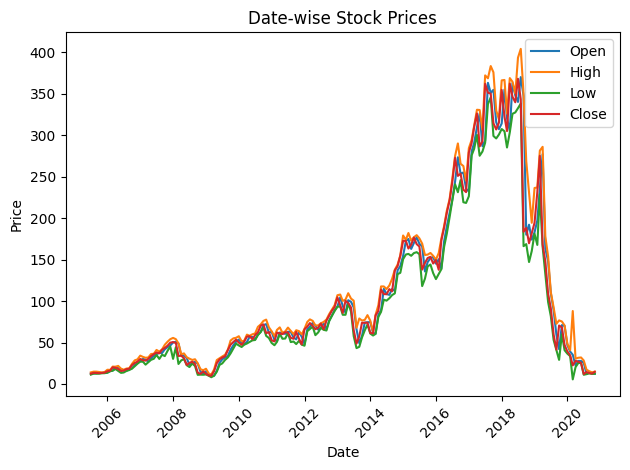

In [12]:
# prompt: plot the date wise operation on every column

for col in df.columns[1:]:
  plt.plot(df['Date'], df[col], label=col)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Date-wise Stock Prices')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
df.corr().style.background_gradient(cmap='coolwarm')

,Date,Open,High,Low,Close
Date,1.000000,0.623355,0.637128,0.597551,0.606019
Open,0.623355,1.000000,0.993040,0.983978,0.977971
High,0.637128,0.993040,1.000000,0.983422,0.985051
Low,0.597551,0.983978,0.983422,1.000000,0.995358
Close,0.606019,0.977971,0.985051,0.995358,1.000000


The correlation matrix shows very high correlations among the stock price features:

- Open vs. High: 0.993
- Open vs. Low: 0.984
- Open vs. Close: 0.978
- High vs. Low: 0.983
- High vs. Close: 0.985
- Low vs. Close: 0.995

{'whiskers': [<matplotlib.lines.Line2D at 0x7c89047ad9c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7c89047ad480>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c890478ba60>,
 'medians': [<matplotlib.lines.Line2D at 0x7c89047acf40>,
 'fliers': [<matplotlib.lines.Line2D at 0x7c89047acca0>,
 'means': []}

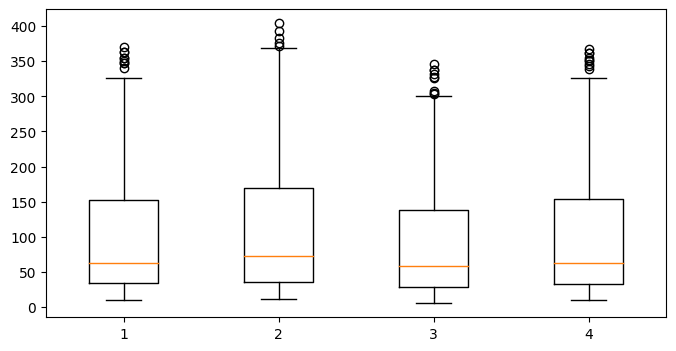

In [14]:
plt.figure(figsize=(8, 4))
plt.boxplot([df['Open'], df['High'], df['Low'], df['Close']])

In [15]:
!pip install statsmodels

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [17]:
vif = variance_inflation_factor
df1 = df.iloc[:,1:]
vif_data = pd.DataFrame()
vif_data['feature'] = df1.columns
vif_data['VIF'] = [vif(df1.values, i) for i in range(df1.shape[1])]
vif_data

,feature,VIF
0,Open,288.504853
1,High,323.952468
2,Low,424.612257
3,Close,428.401649


Feature Engineering

To handle multicollinearity and enhance the model, we can create additional features such as moving averages, monthly returns, and volatility.

- Feature Engineering Steps:
- Moving Averages: Compute short-term and long-term moving averages for the closing prices.
- Monthly Returns: Calculate the percentage change in closing prices month over month.
- Volatility: Measure the standard deviation of the closing prices over a rolling window.

In [18]:
df["mv_avg_5"] = df["Close"].rolling(5).mean() # 3 month moving average
df["mv_avg_10"] = df["Close"].rolling(10).mean() # 10 month moving average

df['monthly_returns'] = df['Close'].pct_change() # Monthly_Return: Month-over-month percentage change in closing prices.
df['volatility'] = df['Close'].rolling(window=30).std() # Volatility: Standard deviation of closing prices over a 30-day window.

In [19]:
df.head()

,Date,Open,High,Low,Close,mv_avg_5,mv_avg_10,monthly_returns,volatility
0,2005-07-01,13.00,14.00,11.25,12.46,NaN,NaN,NaN,NaN
1,2005-08-01,12.58,14.88,12.55,13.42,NaN,NaN,0.077047,NaN
2,2005-09-01,13.48,14.87,12.27,13.30,NaN,NaN,-0.008942,NaN
3,2005-10-01,13.20,14.47,12.40,12.99,NaN,NaN,-0.023308,NaN
4,2005-11-01,13.35,13.88,12.88,13.41,13.116,NaN,0.032333,NaN


<Figure size 1000x600 with 0 Axes>

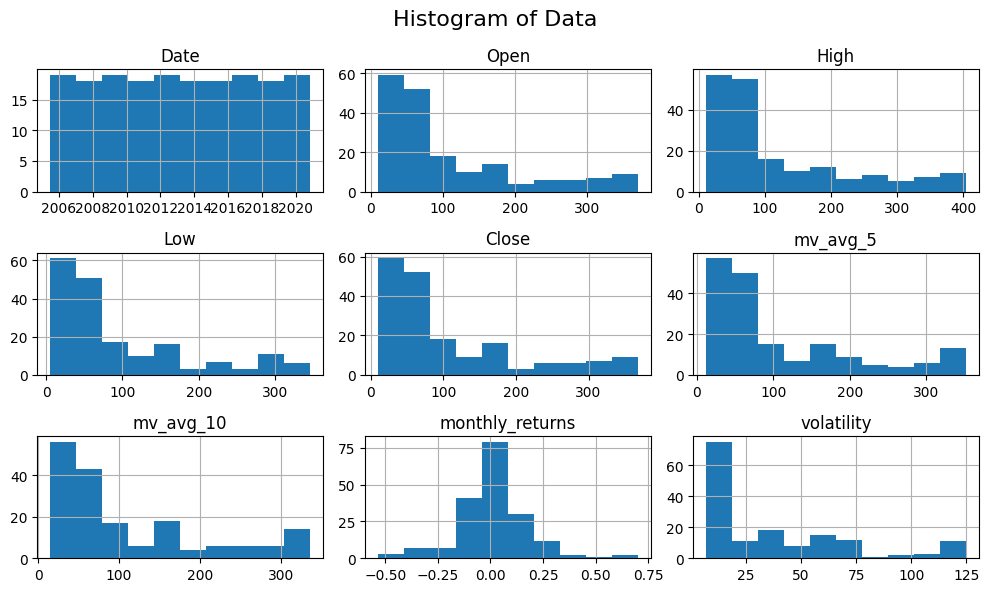

In [20]:
# prompt: plot the skewness of the data

# Plotting the skewness of the data
plt.figure(figsize=(10, 6))
df.hist(figsize=(10, 6))
plt.suptitle('Histogram of Data', fontsize=16)
plt.tight_layout()
plt.show()


Model preparation


In [21]:
df = df.dropna().reset_index(drop=True) # droping the null values in data set


In [22]:
# Define features and target variable
features = df.drop(columns=['Date','Close'])
target = df['Close']

In [23]:
X = features
y = target

Split the data into training and testing sets.
Standardize the features if necessary.

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape
#Training set: 144 samples, 7 features
# Testing set: 36 samples, 7 features

((124, 7), (32, 7), (124,), (32,))

In [27]:
# min_max_scaler = MinMaxScaler()
# X_train = min_max_scaler.fit_transform(X_train)
# X_test = min_max_scaler.transform(X_test)

 - Model Selection and Grid Search Cross-Validation
   
  Choose appropriate models (e.g., Linear Regression, ARIMA).
- Perform Grid Search Cross-Validation to find the best parameters.

In [28]:
from sklearn.model_selection import GridSearchCV


In [31]:
# prompt: import time series ml models

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor


In [46]:
random = RandomForestRegressor()

In [53]:
# prompt: perform gridsearch cross validation and hyperparrameter tuning
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Perform Grid Search Cross-Validation to find the best parameters.
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('regressor', LinearRegression())  # Linear Regression model
])

# 'normalize' is deprecated, use only valid parameters for LinearRegression
param_grid = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False]  # Example of another valid parameter
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'regressor__fit_intercept': True, 'regressor__positive': True}
Best score: -78.91271576963638


In [58]:
# Use the best estimator for prediction
best_regressor = grid_search.best_estimator_
y_pred = best_regressor.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 25.84815763166744
R-squared: 0.9968157758052728


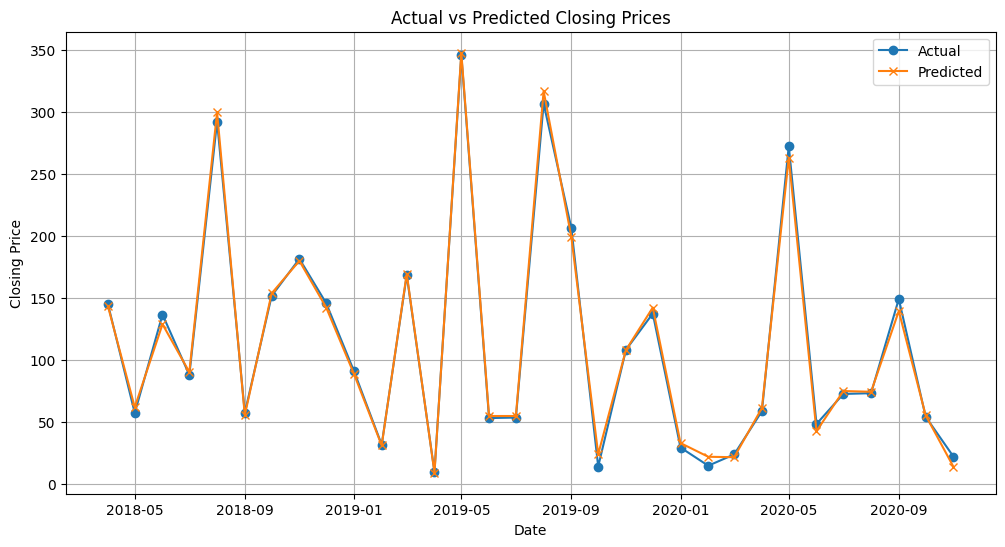

In [61]:
plt.figure(figsize=(12, 6))

plt.plot(df['Date'][-len(y_test):], y_test, label='Actual', marker='o')
plt.plot(df['Date'][-len(y_test):], y_pred, label='Predicted', marker='x')

plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

The plot shows the actual versus predicted closing prices for Yes Bank's stock. The model's predictions align closely with the actual values, demonstrating its effectiveness.

Recommended Next Analyses:
Here are five other recommended analyses we can perform:

- ARIMA Model: Explore ARIMA (AutoRegressive Integrated Moving Average) for time series forecasting.
- LSTM Model: Implement a Long Short-Term Memory (LSTM) neural network for more complex patterns in stock price prediction.
- Feature Importance Analysis: Determine which features are the most important for predicting stock prices.
- Sentiment Analysis: Analyze the impact of news sentiment on stock prices.
- Comparative Analysis: Compare Yes Bank's stock performance with other similar banks in India.